In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [2]:
# Load Data and Preprocess
def load_data(filepath):
    df = pd.read_csv(filepath)
    return df

#================ FOR PCA Dimensionality reduction =========
# Apply PCA for Dimensionality Reduction
def apply_pca(x, n_components):
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(x)
    return x_pca, pca.explained_variance_ratio_

#================ FOR K-Means ===============================
# Find Optimal Clusters for KMeans (Elbow Method)
def find_optimal_clusters(x, max_clusters=10):
    inertia_values = []
    from sklearn.cluster import KMeans

    for k in range(1, max_clusters + 1):
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(x)
        inertia_values.append(model.inertia_)

    return inertia_values

# Perform KMeans Clustering
# Change None to the number of n_clusters value from the elbow method
def perform_kmeans_clustering(x, n_clusters=None):
    from sklearn.cluster import KMeans

    model = KMeans(n_clusters=n_clusters, random_state=42)
    labels = model.fit_predict(x)
    return labels, model

#================ FOR Agglomerative ===============================
# Perform Agglomerative Clustering
# Change None to the number of n_clusters value from the elbow method
def perform_agglomerative_clustering(x, n_clusters=None):
    from sklearn.cluster import AgglomerativeClustering

    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(x)
    return labels, model

#================FOR Dendrogram===============================
# Get Linkages for Dendrogram
def get_linkages(x):
    from scipy.cluster.hierarchy import linkage
    linked = linkage(x, method='ward')
    return linked

# Plot Dendrogram
def plot_dendrogram(linked):
    from scipy.cluster.hierarchy import dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram(linked)
    plt.title("Dendrogram")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()

## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

In [4]:
def load_data(filepath):
    """Load and preprocess the bank marketing dataset.

    TODO:
    1. Load the CSV file (hint: it uses semicolon separator)
    2. Convert categorical columns to numerical using LabelEncoder
    3. Scale the features using StandardScaler
    """
    # Your code here:
    # Load data
    df = pd.read_csv(filepath, sep=';')

    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                       'loan', 'contact', 'month', 'poutcome', 'y']

    # TODO: Apply label encoding to categorical columns
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    # Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 'job', 'education',
               'housing', 'loan', 'default']
    X =df[features]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, df

# Load and preprocess the data
X_scaled, data = load_data('/content/bank-full.csv')
print("Data shape:", X_scaled.shape)

Data shape: (45211, 9)


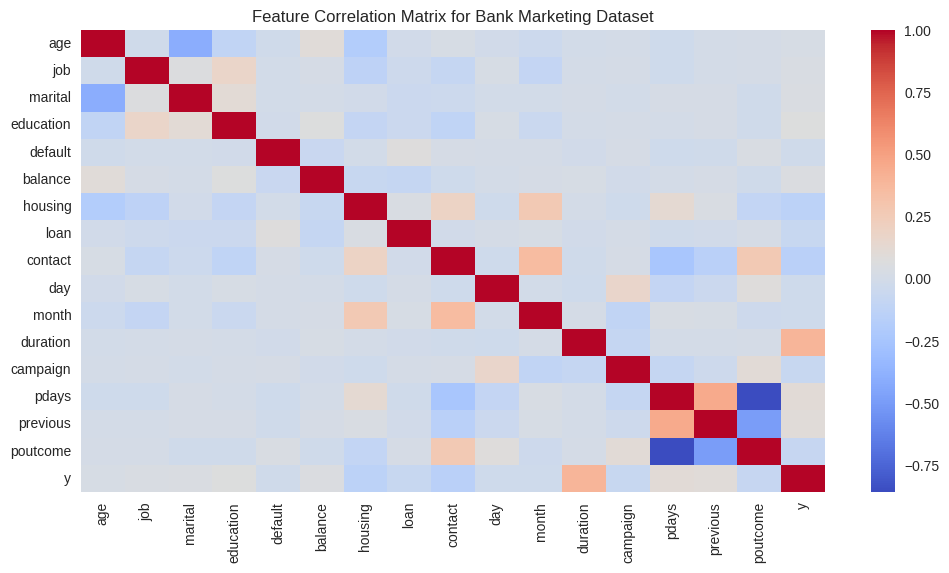

In [15]:
class KMeansClustering:
    """Minimal K-means skeleton for students to implement.

    Students should implement the core methods below:
    - _initialize_centroids
    - _assign_clusters
    - _update_centroids
    - fit

    Keep implementations simple and readable; tests and visualization code will
    use these methods once implemented.
    """
    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Initialize centroids.

        TODO (student):
        - Randomly select `n_clusters` distinct points from X as initial centroids.
        - Return an array of shape (n_clusters, n_features).
        Hint: Use np.random.choice to pick indices.
        """
        np.random.seed(self.random_state)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]

    def _assign_clusters(self, X):
        """Assign each sample in X to the nearest centroid.

        TODO (student):
        - Compute distance from each point to each centroid (Euclidean)
        - Return an integer array of shape (n_samples,) with cluster labels
        Hint: np.linalg.norm with axis manipulation or broadcasting helps here.
        """
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        """Recompute centroids as the mean of points assigned to each cluster.

        TODO (student):
        - For each cluster id in 0..n_clusters-1 compute the mean of points
          assigned to that cluster. If a cluster has no points, consider reinitializing
          its centroid (or leave unchanged) — discuss in your report.
        - Return an array of shape (n_clusters, n_features).
        """
        new_centroids = []
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]

            if len(cluster_points) == 0:
                # If empty cluster → keep old centroid
                new_centroids.append(self.centroids[i])
            else:
                new_centroids.append(cluster_points.mean(axis=0))

        return np.array(new_centroids)

    def fit(self, X):
        """Run K-means until convergence or max_iters.

        TODO (student):
        - Initialize centroids
        - Loop: assign clusters, update centroids
        - Stop early if centroids do not change (or change below a tiny threshold)
        - Store final labels in self.labels and centroids in self.centroids
        - Return self
        """
        self.centroids = self._initialize_centroids(X)

        for _ in range(self.max_iters):
            # Assign points to clusters
            labels = self._assign_clusters(X)

            # Compute new centroids
            new_centroids = self._update_centroids(X, labels)

            # Stop if centroids stop changing
            if np.allclose(self.centroids, new_centroids, atol=1e-6):
                break

            self.centroids = new_centroids

        self.labels = labels
        return self

    def predict(self, X):
        """Assign cluster labels to X using the learned centroids.

        Implementation may call _assign_clusters but should error if centroids
        are not yet initialized (i.e., if fit wasn't called).
        """
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        return self._assign_clusters(X)

# Feature Correlation Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Matrix for Bank Marketing Dataset")
plt.show()

## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

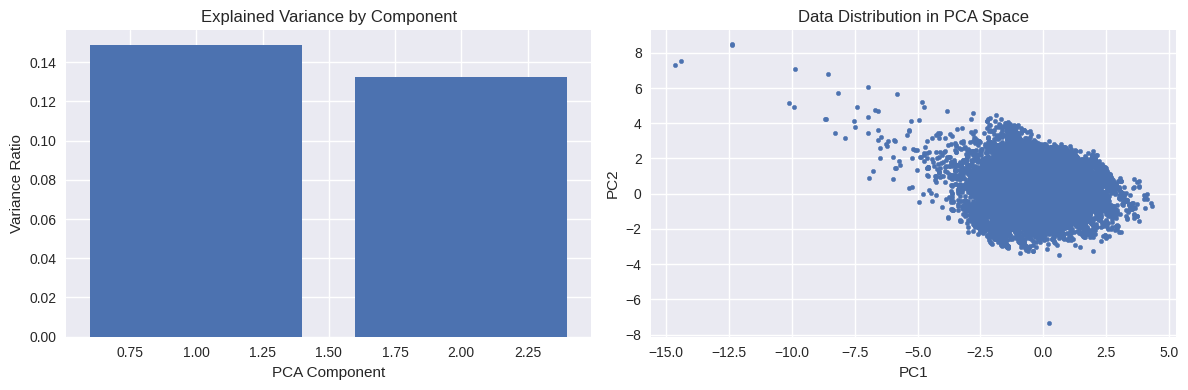

Shape after PCA: (45211, 2)


In [6]:
def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction.

    TODO:
    1. Initialize and fit PCA
    2. Transform the data
    3. Create visualizations to understand:
       - Explained variance ratio
       - Cumulative explained variance
       - Data distribution in 2D
    """
    # Your code here:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # TODO: Create visualization
    plt.figure(figsize=(12, 4))

    # Plot explained variance
    plt.subplot(1, 2, 1)
    plt.bar(range(1, n_components+1), pca.explained_variance_ratio_)
    plt.title("Explained Variance by Component")
    plt.xlabel("PCA Component")
    plt.ylabel("Variance Ratio")

    # Plot data in 2D
    plt.subplot(1, 2, 2)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10)
    plt.title("Data Distribution in PCA Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.tight_layout()
    plt.show()

    return X_pca

# Apply PCA
X_pca = apply_pca(X_scaled)
print("Shape after PCA:", X_pca.shape)

## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

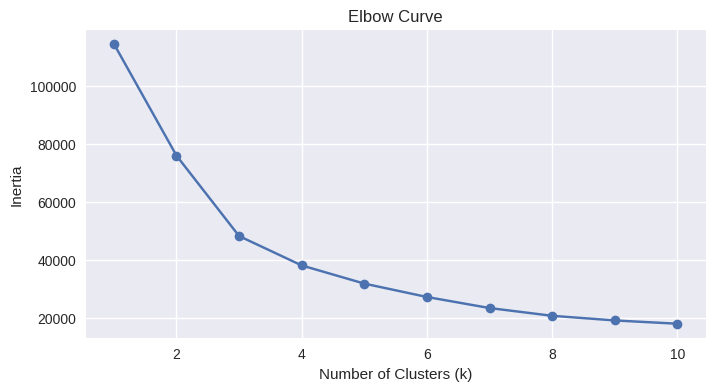

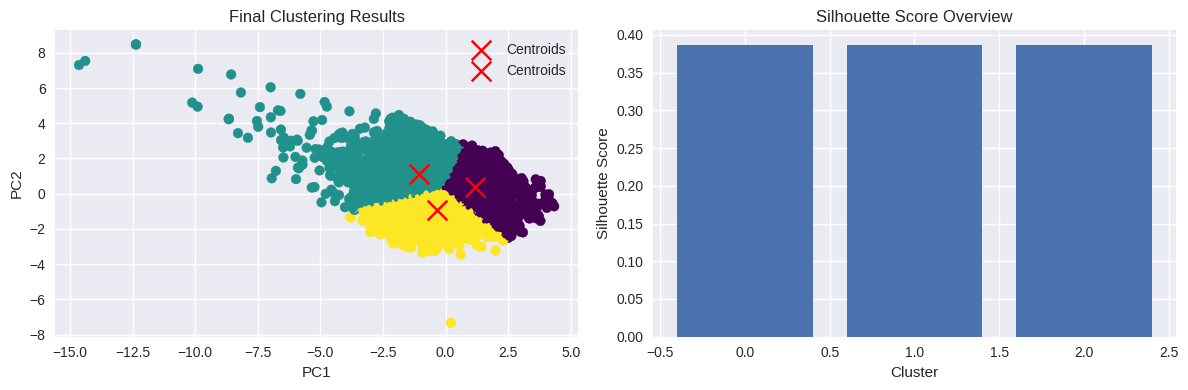


Clustering Evaluation:
Inertia: 48179.64
Silhouette Score: 0.39


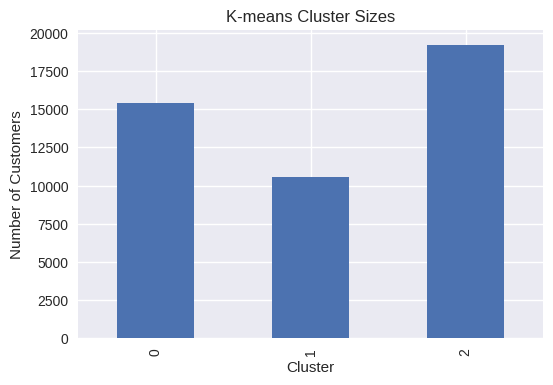

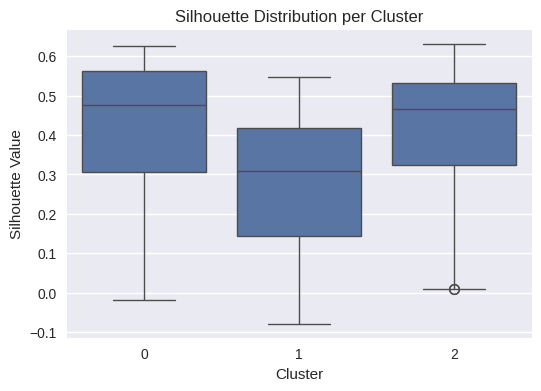

In [14]:
def calculate_inertia(X, labels, centroids):
    """Calculate the within-cluster sum of squares (inertia).

    TODO:
    1. For each cluster, calculate the sum of squared distances
       between points and their centroid
    2. Sum up all cluster distances
    """
    # Your code here
    inertia = 0
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        distances = np.linalg.norm(cluster_points - centroids[i], axis=1)
        inertia += np.sum(distances ** 2)
    return inertia

def plot_elbow_curve(X, max_k=10):
    """Plot the elbow curve to find optimal number of clusters.

    TODO:
    1. Try different values of k (1 to max_k)
    2. Calculate inertia for each k
    3. Plot k vs inertia
    4. Help identify the 'elbow' point
    """
    inertias = []
    K = range(1, max_k + 1)
    for k in K:
        model = KMeansClustering(n_clusters=k)
        model.fit(X)
        inertia_k = calculate_inertia(X, model.labels, model.centroids)
        inertias.append(inertia_k)

    # Create elbow plot
    plt.figure(figsize=(8, 4))
    plt.plot(K, inertias, marker='o')
    plt.title("Elbow Curve")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

    return inertias

# Try different numbers of clusters
inertias = plot_elbow_curve(X_pca)

# Apply final clustering
kmeans = KMeansClustering(n_clusters=3)  # Try different values based on elbow curve
kmeans.fit(X_pca)

# Visualize final results
plt.figure(figsize=(12, 4))

# Plot clusters
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1],
            c='red', marker='x', s=200, label='Centroids')
plt.title('Final Clustering Results')
plt.legend()

# Plot evaluation metrics
plt.subplot(1, 2, 2)
# Your code here: Add relevant evaluation metric plots
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis', s=10)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1],
            c='red', marker='x', s=200, label='Centroids')
plt.title('Final Clustering Results')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(len(set(kmeans.labels))),
        [np.mean(silhouette_score(X_pca, kmeans.labels))] * len(set(kmeans.labels)))
plt.title("Silhouette Score Overview")
plt.xlabel("Cluster")
plt.ylabel("Silhouette Score")


plt.tight_layout()
plt.show()

# Calculate and print evaluation metrics
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
silhouette = silhouette_score(X_pca, kmeans.labels)

print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")


cluster_counts = pd.Series(kmeans.labels).value_counts().sort_index()

plt.figure(figsize=(6,4))
cluster_counts.plot(kind='bar')
plt.title("K-means Cluster Sizes")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()


from sklearn.metrics import silhouette_samples

sil_values = silhouette_samples(X_pca, kmeans.labels)

plt.figure(figsize=(6,4))
sns.boxplot(x=kmeans.labels, y=sil_values)
plt.title("Silhouette Distribution per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Silhouette Value")
plt.show()

## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

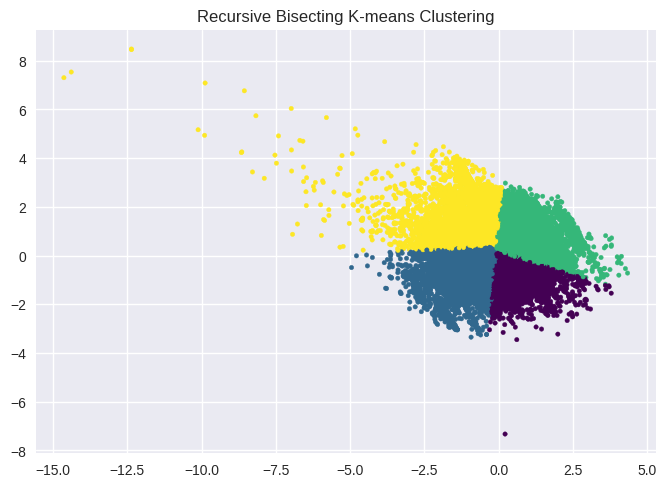

In [13]:
from sklearn.cluster import KMeans
class BisectingKMeans:
    """Concise skeleton for students to implement a bisecting K-means algorithm.

    Students should implement `fit_predict` to recursively split clusters until
    `n_clusters` is reached.
    """
    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.labels_ = None
        # Optional: store mapping parent -> (left_label, right_label)
        self.split_tree = {}
        # Optional: store centroids per cluster id
        self.centers_ = {}

    def fit_predict(self, X):
        """Recursively bisect clusters until `n_clusters` is reached.

        TODO (student):
        - Start with all points assigned to label 0.
        - While number of unique labels < n_clusters:
            - Select a cluster to split (e.g., the largest cluster by size)
            - Run a binary KMeans (k=2) on the points in that cluster
            - Assign new labels (keep one child label as the original, give the other a new id)
            - Record parent -> (left, right) in `self.split_tree` and centroids in `self.centers_`
        - Set and return `self.labels_` (numpy array of length n_samples)

        Hints:
        - Use sklearn.cluster.KMeans(n_clusters=2, random_state=self.random_state) for the split step
        - Keep a counter for new label ids and increment when creating a new cluster
        - Use boolean indexing to operate on subsets of X efficiently
        """
        n_samples = X.shape[0]

        # Start: all points belong to cluster 0
        labels = np.zeros(n_samples, dtype=int)
        current_clusters = {0: np.arange(n_samples)}  # cluster_id -> indices
        next_label_id = 1  # new clusters get labels 1, 2, 3 ...

        # Continue splitting until we reach n_clusters clusters
        while len(current_clusters) < self.n_clusters:

            # --- 1. Pick the largest cluster to split ---
            cluster_to_split = max(current_clusters, key=lambda c: len(current_clusters[c]))
            indices = current_clusters[cluster_to_split]
            subset = X[indices]

            # --- 2. Apply KMeans with k = 2 ---
            km = KMeans(n_clusters=2, random_state=self.random_state)
            split_labels = km.fit_predict(subset)

            # Two groups inside the parent cluster
            left_indices = indices[split_labels == 0]
            right_indices = indices[split_labels == 1]

            # --- 3. Assign labels ---
            # Keep original label for left child
            current_clusters[cluster_to_split] = left_indices

            # Assign new label for right child
            new_cluster_id = next_label_id
            next_label_id += 1
            current_clusters[new_cluster_id] = right_indices

            # --- 4. Save split info ---
            self.split_tree[cluster_to_split] = (cluster_to_split, new_cluster_id)
            self.centers_[cluster_to_split] = km.cluster_centers_[0]
            self.centers_[new_cluster_id] = km.cluster_centers_[1]

        # Build final label array
        final_labels = np.zeros(n_samples, dtype=int)
        for cid, idxs in current_clusters.items():
          final_labels[idxs] = cid

        self.labels_ = final_labels
        return final_labels


# Example (for instructor use only):
# bisect = BisectingKMeans(n_clusters=4)
# labels = bisect.fit_predict(X_pca)
# plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)

bisect = BisectingKMeans(n_clusters=4)
labels_bisect = bisect.fit_predict(X_pca)

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_bisect, cmap='viridis', s=10)
plt.title("Recursive Bisecting K-means Clustering")
plt.show()



## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!